# Imports

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from src.data.loader import load_prices, compute_returns, ajustar_risk_free
from outputs.charts.markowitz_plot import plot_time_serie, plot_efficient_frontier, markowitz_tradeoff
from src.optimization.markowitz import minimize_volatility, solve_markowitz
from src.optimization.sharpe import maximize_sharpe
from src.optimization.markowitz import minimize_volatility, portfolio_return, portfolio_volatility

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# User input

In [2]:
tickers = ["PETR4.SA", "VALE3.SA", "ITUB4.SA", "BBDC4.SA", "BBAS3.SA", "ABEV3.SA", "WEGE3.SA", "B3SA3.SA", "GGBR4.SA"] # "MGLU3.SA"
start_date = "2017-01-01"
end_date = "2023-01-01"

# Frequência desejada: 'daily', 'weekly', 'monthly', 'annual'
#frequencia_retorno = 'monthly'
#target_return = 0.01
risk_free_rate = 0.15

# Levantando estatística dos dados

In [3]:


prices = load_prices(tickers, start=start_date, end=end_date)

returns_daily = compute_returns(prices, freq='daily')

mean_returns_daily = returns_daily.mean()
cov_matrix_daily = returns_daily.cov()

returns_monthly = compute_returns(prices, freq='monthly')

mean_returns_monthly = returns_monthly.mean()
cov_matrix_monthly = returns_monthly.cov()



/workspaces/deep_learning_finance/src/data/loader.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start, end=end)['Close']
[*********************100%***********************]  9 of 9 completed
/workspaces/deep_learning_finance/src/data/loader.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled = prices.resample(freq_map[freq]).last()


In [4]:
print(mean_returns_daily)

Ticker
ABEV3.SA    0.000230
B3SA3.SA    0.001046
BBAS3.SA    0.000731
BBDC4.SA    0.000414
GGBR4.SA    0.001257
ITUB4.SA    0.000485
PETR4.SA    0.001295
VALE3.SA    0.001449
WEGE3.SA    0.001596
dtype: float64


In [5]:
cov_matrix_daily

Ticker,ABEV3.SA,B3SA3.SA,BBAS3.SA,BBDC4.SA,GGBR4.SA,ITUB4.SA,PETR4.SA,VALE3.SA,WEGE3.SA
Ticker,,,,,,,,,
ABEV3.SA,0.000338,0.000193,0.000203,0.000204,0.000168,0.000184,0.000205,0.000096,0.000161
B3SA3.SA,0.000193,0.000624,0.000381,0.000325,0.000277,0.000292,0.000350,0.000183,0.000264
BBAS3.SA,0.000203,0.000381,0.000659,0.000466,0.000335,0.000401,0.000497,0.000233,0.000202
BBDC4.SA,0.000204,0.000325,0.000466,0.000515,0.000298,0.000402,0.000396,0.000210,0.000179
GGBR4.SA,0.000168,0.000277,0.000335,0.000298,0.000760,0.000264,0.000430,0.000461,0.000237
ITUB4.SA,0.000184,0.000292,0.000401,0.000402,0.000264,0.000420,0.000337,0.000172,0.000168
PETR4.SA,0.000205,0.000350,0.000497,0.000396,0.000430,0.000337,0.000866,0.000321,0.000233
VALE3.SA,0.000096,0.000183,0.000233,0.000210,0.000461,0.000172,0.000321,0.000655,0.000146
WEGE3.SA,0.000161,0.000264,0.000202,0.000179,0.000237,0.000168,0.000233,0.000146,0.000532


In [6]:
weights_markowitz_daily = minimize_volatility(mean_returns_daily, cov_matrix_daily)
weights_markowitz_monthly = minimize_volatility(mean_returns_monthly, cov_matrix_monthly)

In [7]:
# necesario ajustar (esta fixado em diario)
risk_free_rate_annual = 0.15
risk_free_rate_daily = (1 + risk_free_rate_annual) ** (1/252) - 1

weights_sharpe = maximize_sharpe(mean_returns_daily, cov_matrix_daily, risk_free_rate=risk_free_rate_daily)

In [8]:
df_pesos = pd.DataFrame({
    "Ticker": tickers,
    "Peso Markowitz": weights_markowitz_daily,
    "Peso Markowitz Monthly": weights_markowitz_monthly,
    "Peso Sharpe": weights_sharpe
})
print(df_pesos.sort_values("Peso Sharpe", ascending=False).round(4))


     Ticker  Peso Markowitz  Peso Markowitz Monthly  Peso Sharpe
8  GGBR4.SA          0.1760                  0.2679       0.6245
7  B3SA3.SA          0.1935                  0.3036       0.3576
6  WEGE3.SA          0.0000                  0.0000       0.0179
4  BBAS3.SA          0.0000                  0.0000       0.0000
1  VALE3.SA          0.0095                  0.0054       0.0000
0  PETR4.SA          0.4291                  0.2733       0.0000
2  ITUB4.SA          0.0000                  0.1498       0.0000
3  BBDC4.SA          0.0000                  0.0000       0.0000
5  ABEV3.SA          0.1920                  0.0000       0.0000


### Visualização de Fronteira e Crescimento


🔹 Gráficos para Sharpe


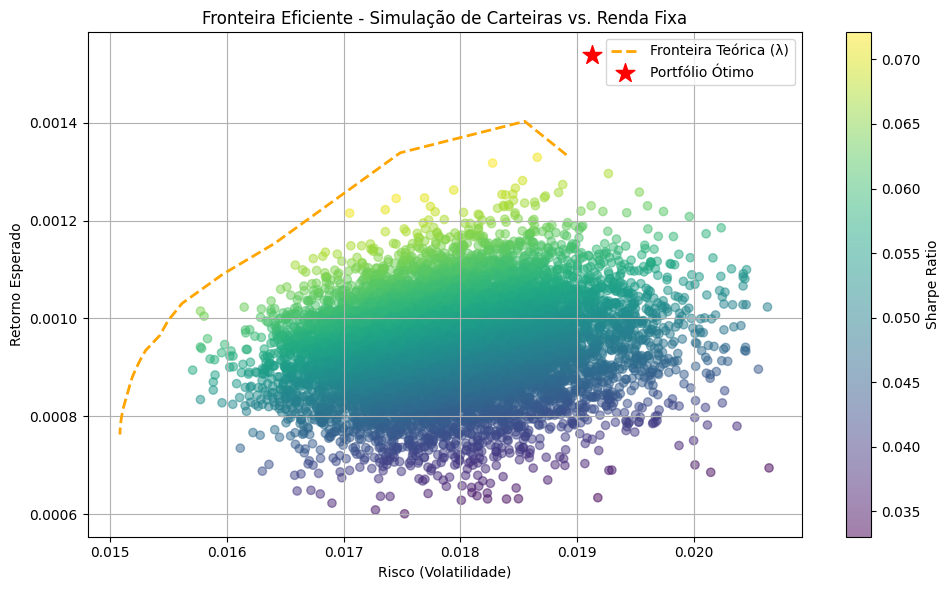

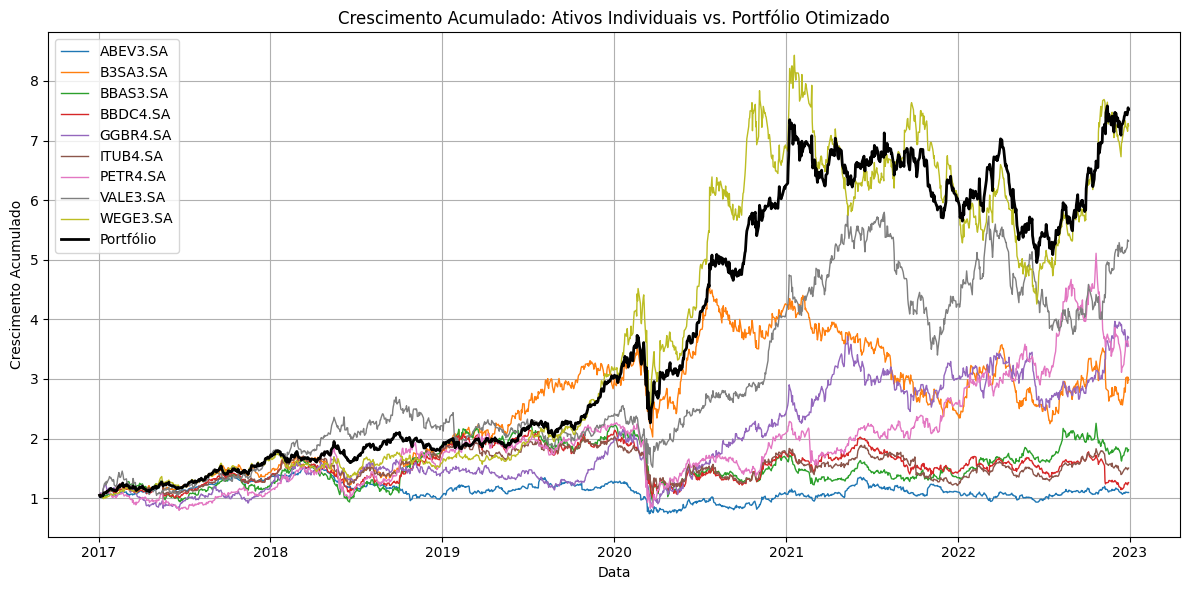


🔹 Gráficos para Markowitz Monthly


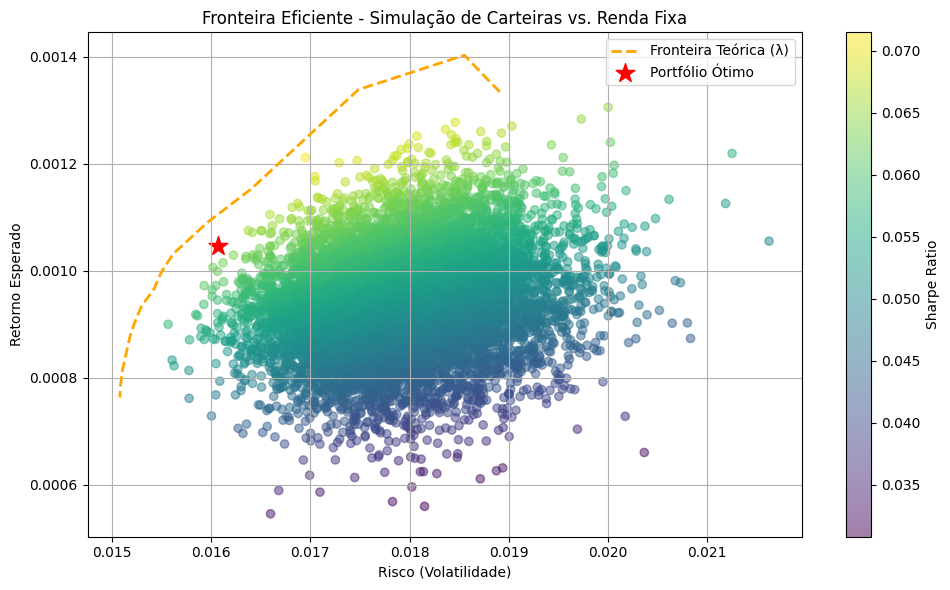

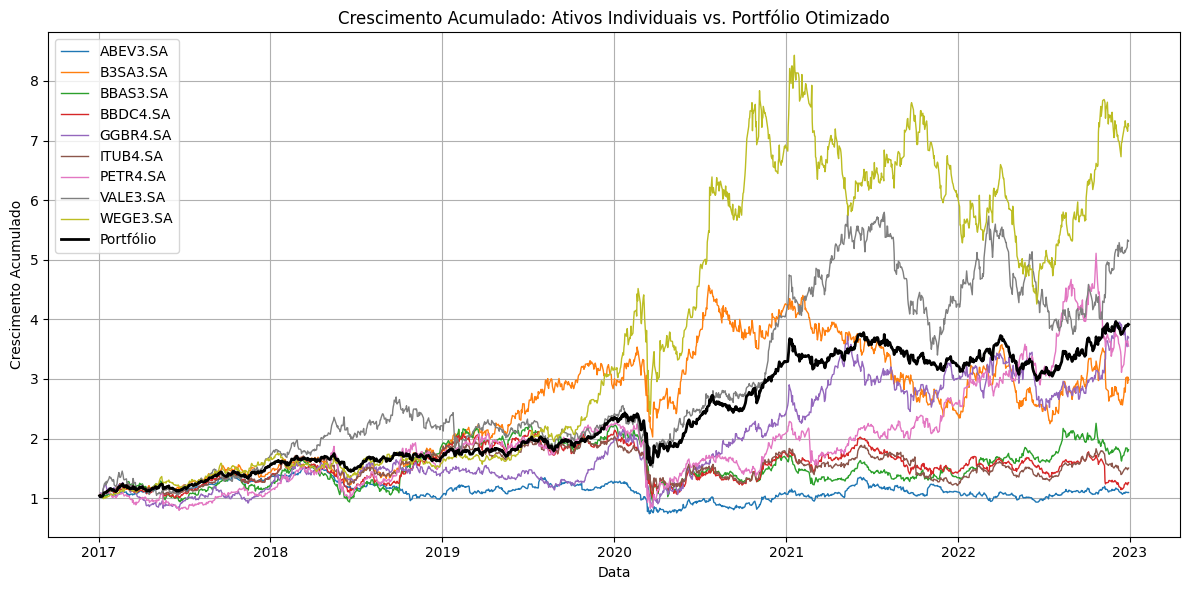


🔹 Gráficos para Markowitz Daily


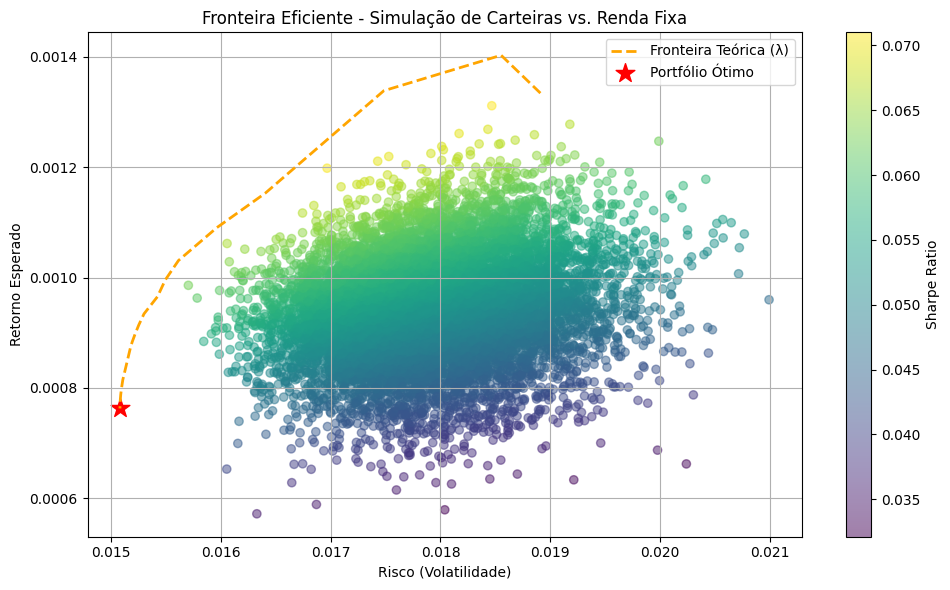

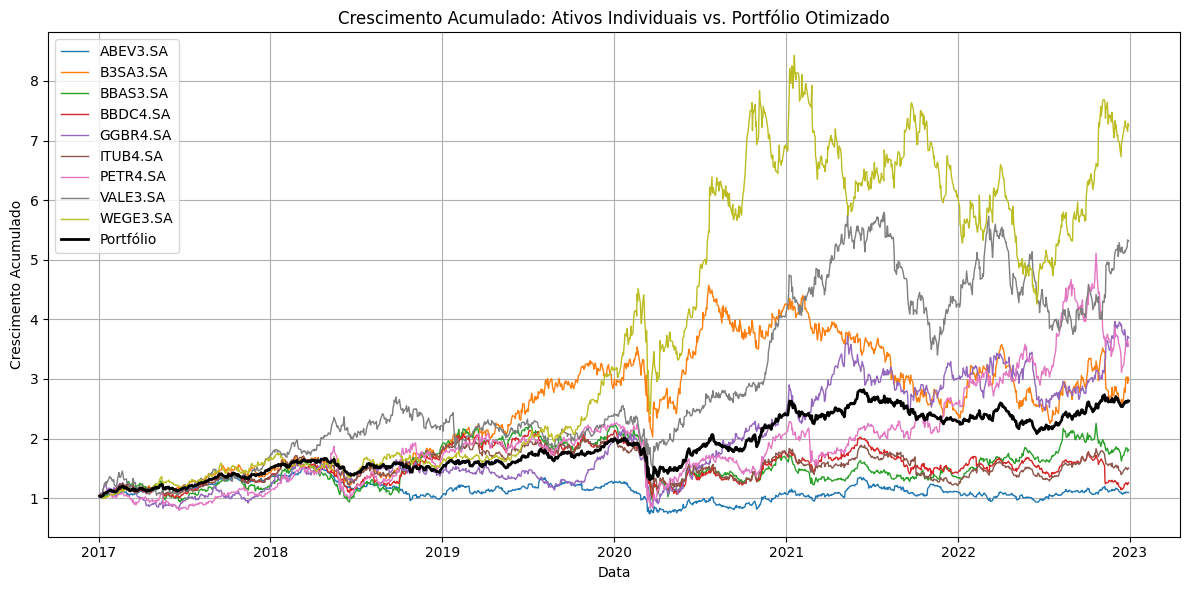

In [9]:
for nome, pesos in [("Sharpe", weights_sharpe), ("Markowitz Monthly", weights_markowitz_monthly), ("Markowitz Daily", weights_markowitz_daily)]:
    print(f"\n🔹 Gráficos para {nome}")
    plot_efficient_frontier(mean_returns_daily, cov_matrix_daily, optimized_weights=pesos)
    plot_time_serie(returns_daily, optimized_weights=pesos)

# tentar fazer em um memso plot a fronteira para diario, mensal. claro, convertendo no mensal para o valor em mesmes

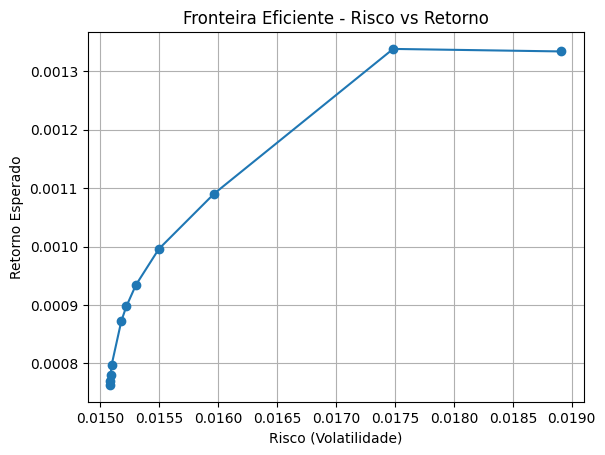

In [10]:
ret_list_daily, vol_list_daily= markowitz_tradeoff(mean_returns_daily, cov_matrix_daily, interval=0.1)

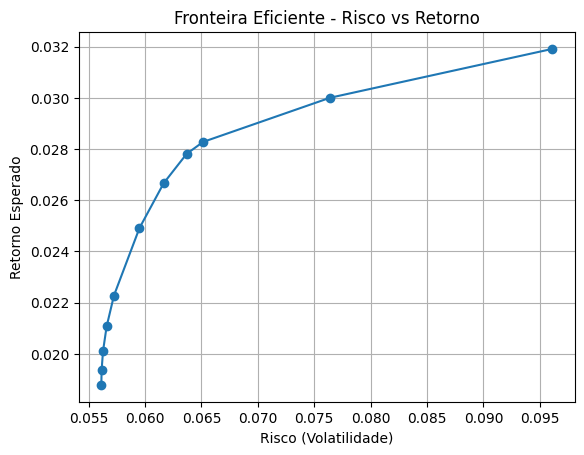

In [11]:
ret_list_monthly, vol_list_monthly= markowitz_tradeoff(mean_returns_monthly, cov_matrix_monthly, interval=0.1) # a parte mais a esquerde representa a fronteira de pareto
# a estimativa da medai tem q sair de uma rede neural
#gerando um preditor de media, a aprtir de retornos diarios anteriores

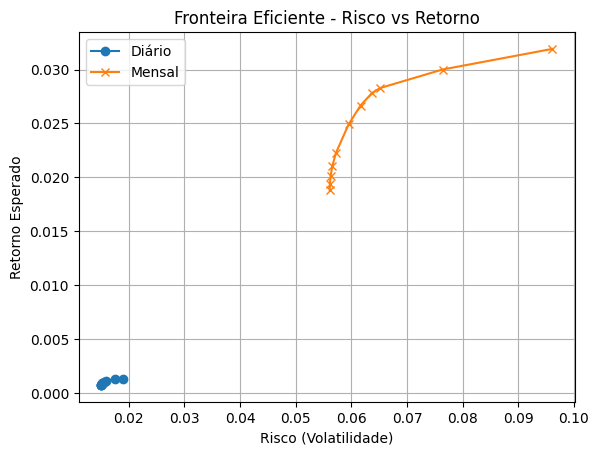

In [14]:
plt.plot(vol_list_daily, ret_list_daily, marker='o', label='Diário')
plt.plot(vol_list_monthly, ret_list_monthly, marker='x', label='Mensal')
plt.title("Fronteira Eficiente - Risco vs Retorno")
plt.xlabel("Risco (Volatilidade)")
plt.ylabel("Retorno Esperado")
plt.grid()
plt.legend()
plt.show()

In [ ]:
ret_list_daily_acum = []
vol_list_daily_acum = []
# converte um retono diario se aplicando por 21 dias para obter em mensal
for ret, vol in zip(ret_list_daily, vol_list_daily):
    ret_monthly = (1 + ret) ** 21 - 1 # potencia pois os retornos se compoem um sobre o anterior, o que nao acontece na mult
    #ret_annualy = (1 + ret) ** 252 - 1 # retorno diario -> anual

    vol_monthly = vol * np.sqrt(21)
    #vol_annualy = vol * np.sqrt(252)

    ret_list_daily_acum.append(ret_monthly)
    #ret_list_daily_acum.append(ret_monthly)

    vol_list_daily_acum.append(vol_monthly)
    #vol_list_daily_acum.append(vol_monthly)

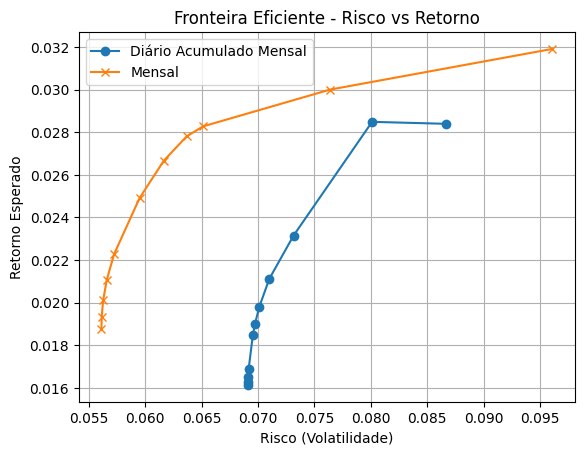

In [16]:
plt.plot(vol_list_daily_acum, ret_list_daily_acum, marker='o', label='Diário Acumulado Mensal')
plt.plot(vol_list_monthly, ret_list_monthly, marker='x', label='Mensal')
plt.title("Fronteira Eficiente - Risco vs Retorno")
plt.xlabel("Risco (Volatilidade)")
plt.ylabel("Retorno Esperado")
plt.grid()
plt.legend()
plt.show()

In [17]:
vol_list_daily_acum

[np.float64(0.08665533798839638),
 np.float64(0.08012230057571218),
 np.float64(0.07315640691077377),
 np.float64(0.07100725876237275),
 np.float64(0.07011944903485483),
 np.float64(0.06974626500470407),
 np.float64(0.06955043864299858),
 np.float64(0.06917394717243527),
 np.float64(0.06913315091171783),
 np.float64(0.06911969361741852),
 np.float64(0.06911716386443835)]

In [ ]:
# sharpe ratio individual com 100% de investimento em um ativo
sharpe_individual = (mean_returns - risk_free_rate_daily) / np.sqrt(np.diag(cov_matrix))
print(sharpe_individual.sort_values(ascending=False))

Ticker
WEGE3.SA    0.326261
VALE3.SA    0.262533
PETR4.SA    0.205304
GGBR4.SA    0.200594
B3SA3.SA    0.181378
BBAS3.SA    0.110646
ITUB4.SA    0.086821
BBDC4.SA    0.059286
ABEV3.SA    0.036867
dtype: float64


In [14]:
ret_sharpe = portfolio_return(weights_sharpe, mean_returns)
vol_sharpe = portfolio_volatility(weights_sharpe, cov_matrix)
sharpe_ratio = (ret_sharpe - risk_free_rate_daily) / vol_sharpe

print("\nMétricas do Portfólio (Sharpe)")
print("Retorno:", ret_sharpe * 252)  # anualizado
print("Volatilidade:", vol_sharpe * 252)
print("Sharpe Ratio:", sharpe_ratio * 252)


Métricas do Portfólio (Sharpe)
Retorno: 7.0189635660921645
Volatilidade: 16.074231841320113
Sharpe Ratio: 107.84646244894721


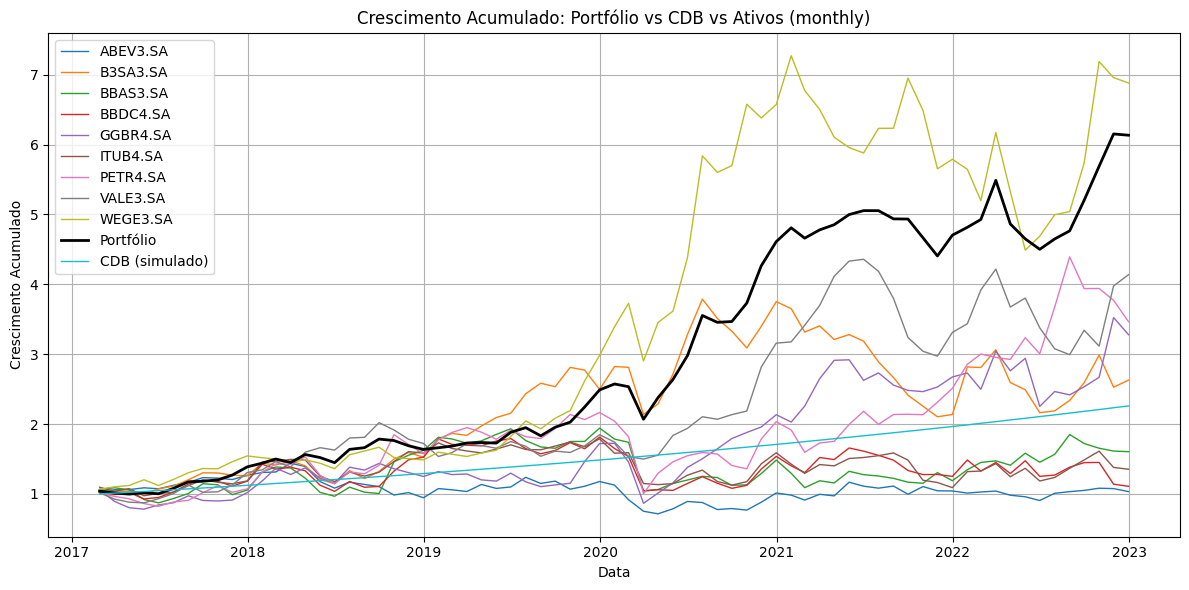

In [15]:
# Definindo taxa anual de benchmark (CDB/CDI)
from outputs.charts.markowitz_plot import compute_benchmark_growth

##cdi_annual = 0.1365

# Número de períodos com base nos retornos calculados
num_periods = len(returns)

# Crescimento acumulado simulado do benchmark
cdb_growth = compute_benchmark_growth(risk_free_rate, frequencia_retorno, num_periods)

returns_acumulados = (1 + returns).cumprod()
returns_acumulados["Portfólio"] = (1 + returns.dot(weights_sharpe)).cumprod()
returns_acumulados["CDB (simulado)"] = cdb_growth

plt.figure(figsize=(12, 6))
for col in returns_acumulados.columns:
    linewidth= 2 if col == 'Portfólio' else 1
    color = 'black' if col == 'Portfólio' else None
    plt.plot(returns_acumulados.index, returns_acumulados[col], label=col, linestyle='-', linewidth=linewidth, color=color)
    

plt.title(f"Crescimento Acumulado: Portfólio vs CDB vs Ativos ({frequencia_retorno})")
plt.xlabel("Data")
plt.ylabel("Crescimento Acumulado")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()